<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import warnings

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, cross_val_predict
import statsmodels.api as sm

sns.set_style('whitegrid')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
warnings.filterwarnings('ignore')

house = pd.read_csv('./housing.csv')     # Load the data
df = house.copy()                        # Make a copy of house for EDA purposes
df.drop(columns=["Id"], axis=1, inplace=True)   # Drop Id column

In [2]:
print(house.shape,'\n')
print(house.columns,'\n')
print(house.head(),'\n')
print(house.dtypes,'\n')
print(house.describe(),'\n')
print(house.info(),'\n')

(1460, 81) 

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond'

In [3]:
# Check for "nulls" values in features
# print value counts (with percentage %) for all 'objects' with more than 1 null value

def object_vcs_and_nulls(df):
    for i in df:
        if df[i].dtype == 'O':
            if df[i].isnull().sum() > 0:
                print(df[i].value_counts())  
                print("Number of Null Values: " + str(df[i].isnull().sum()))
                print("Percentage of Nulls = " + str(np.round((df[i].isnull().sum() / 14.60), 2)) + "%")
                print("\n")
      
object_vcs_and_nulls(df)

Grvl    50
Pave    41
Name: Alley, dtype: int64
Number of Null Values: 1369
Percentage of Nulls = 93.77%


None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64
Number of Null Values: 8
Percentage of Nulls = 0.55%


TA    649
Gd    618
Ex    121
Fa     35
Name: BsmtQual, dtype: int64
Number of Null Values: 37
Percentage of Nulls = 2.53%


TA    1311
Gd      65
Fa      45
Po       2
Name: BsmtCond, dtype: int64
Number of Null Values: 37
Percentage of Nulls = 2.53%


No    953
Av    221
Gd    134
Mn    114
Name: BsmtExposure, dtype: int64
Number of Null Values: 38
Percentage of Nulls = 2.6%


Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
Name: BsmtFinType1, dtype: int64
Number of Null Values: 37
Percentage of Nulls = 2.53%


Unf    1256
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64
Number of Null Values: 38
Percentage of Nulls = 2.6%


SBrkr    1334
FuseA      94
FuseF      27
FuseP   

In [4]:
# check for "non-nulls" in other features
def object_vcs_and_no_nulls(df):
    for i in df:
        if df[i].dtype == 'O':
            if df[i].isnull().sum() == 0:
                print(df[i].value_counts())
                print("Number of Null Values: " + str(df[i].isnull().sum()))
                print("Percentage of Nulls = " + str(np.round((df[i].isnull().sum() / 14.60), 2)) + "%")
                print("\n")
      
object_vcs_and_no_nulls(house)

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64
Number of Null Values: 0
Percentage of Nulls = 0.0%


Pave    1454
Grvl       6
Name: Street, dtype: int64
Number of Null Values: 0
Percentage of Nulls = 0.0%


Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64
Number of Null Values: 0
Percentage of Nulls = 0.0%


Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64
Number of Null Values: 0
Percentage of Nulls = 0.0%


AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64
Number of Null Values: 0
Percentage of Nulls = 0.0%


Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64
Number of Null Values: 0
Percentage of Nulls = 0.0%


Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64
Number of Null Values: 0
Percentage of Nulls = 0.0%


NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst    

In [5]:
# Further investigation - groupby all categorical features vs SalePrice - mean house price.
def mean_prices_categorical_var(df):
    for i in df:
        if df[i].dtype == 'O':
            print(df.groupby(i, as_index=True)['SalePrice'].mean().sort_values(ascending=False))  
            print("\n")
            
print(mean_prices_categorical_var(house))

MSZoning
FV         214014.061538
RL         191004.994787
RH         131558.375000
RM         126316.830275
C (all)     74528.000000
Name: SalePrice, dtype: float64


Street
Pave    181130.538514
Grvl    130190.500000
Name: SalePrice, dtype: float64


Alley
Pave    168000.585366
Grvl    122219.080000
Name: SalePrice, dtype: float64


LotShape
IR2    239833.365854
IR3    216036.500000
IR1    206101.665289
Reg    164754.818378
Name: SalePrice, dtype: float64


LandContour
HLS    231533.940000
Low    203661.111111
Lvl    180183.746758
Bnk    143104.079365
Name: SalePrice, dtype: float64


Utilities
AllPub    180950.95682
NoSeWa    137500.00000
Name: SalePrice, dtype: float64


LotConfig
CulDSac    223854.617021
FR3        208475.000000
Corner     181623.425856
FR2        177934.574468
Inside     176938.047529
Name: SalePrice, dtype: float64


LandSlope
Sev    204379.230769
Mod    196734.138462
Gtl    179956.799566
Name: SalePrice, dtype: float64


Neighborhood
NoRidge    335295.317073
Nr

NoRidge homes have a mean price of $335K, the highest in the dataset, and more than 3 times as high as the mean in MeadowV.

In [6]:
df.groupby('Neighborhood', as_index=True)['SalePrice'].median().sort_values(ascending=False)

Neighborhood
NridgHt    315000
NoRidge    301500
StoneBr    278000
Timber     228475
Somerst    225500
Veenker    218000
Crawfor    200624
ClearCr    200250
CollgCr    197200
Blmngtn    191000
NWAmes     182900
Gilbert    181000
SawyerW    179900
Mitchel    153500
NPkVill    146000
NAmes      140000
SWISU      139500
Blueste    137500
Sawyer     135000
BrkSide    124300
Edwards    121750
OldTown    119000
BrDale     106000
IDOTRR     103000
MeadowV     88000
Name: SalePrice, dtype: int64

NoRidge is no longer the highest in the dataset. Most values comes down with median, which provides an insight that these are most likely due to outliers. However there is no need to clean out the outliers as the differences are not that big.

In [7]:
# Adding "TotalLivingSF" column
df['TotalLivingSF'] = df['GrLivArea'] + df['TotalBsmtSF'] - df['LowQualFinSF']

In [8]:
# Calculates mean price per square foot
mean_price_per_square_foot = df.groupby('Neighborhood', as_index=True)['SalePrice'].mean()  / df.groupby('Neighborhood', as_index=True)['TotalLivingSF'].mean()
mean_price_per_square_foot.sort_values(ascending=False)

Neighborhood
StoneBr    91.267401
NridgHt    89.880781
NoRidge    83.769175
Veenker    83.460439
Somerst    82.650358
Timber     78.046283
Gilbert    76.844541
CollgCr    75.041421
Crawfor    74.769681
SawyerW    71.135475
ClearCr    70.917618
Blmngtn    70.801560
Blueste    67.700640
NWAmes     65.605563
Mitchel    65.414034
NPkVill    65.273189
BrkSide    63.704292
Sawyer     62.675327
NAmes      62.495892
BrDale     60.503746
MeadowV    57.569824
Edwards    57.244515
OldTown    56.503438
SWISU      56.219783
IDOTRR     53.852684
dtype: float64

StoneBr is the most valuable neighbour followed closeby NridgeHt.    

In [9]:
house.isnull().sum().sort_values(ascending=False).head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
Utilities          0
dtype: int64

##### Investigating null values to confirm if these null values are valid or missing values.

In [10]:
house[(house['PoolQC'].isnull()) & (house['PoolArea'] !=0)]  # null PoolQC implies there is no pool

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


In [11]:
house["Alley"].value_counts()  # NaN values imply that there is no alley

Grvl    50
Pave    41
Name: Alley, dtype: int64

In [12]:
house["Fence"].value_counts()  # NaN values imply that there is no fence

MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: Fence, dtype: int64

In [13]:
house[(house['FireplaceQu'].isnull()) & (house['Fireplaces'] !=0)]  # Nan values imply there is no fireplace

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


In [14]:
house[house["LotFrontage"].isnull()][["LotFrontage", "LotArea"]]  # null does not mean LotArea = 0. But it just meant there is no frontage

,LotFrontage,LotArea
7,NaN,10382
12,NaN,12968
14,NaN,10920
16,NaN,11241
24,NaN,8246
31,NaN,8544
42,NaN,9180
43,NaN,9200
50,NaN,13869
64,NaN,9375


In [15]:
house[(house['GarageType'].isnull()) & (house['GarageArea'] != 0)]  # Null values of GarageType means that there is no garage.

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000027C0B080978>]],
      dtype=object)

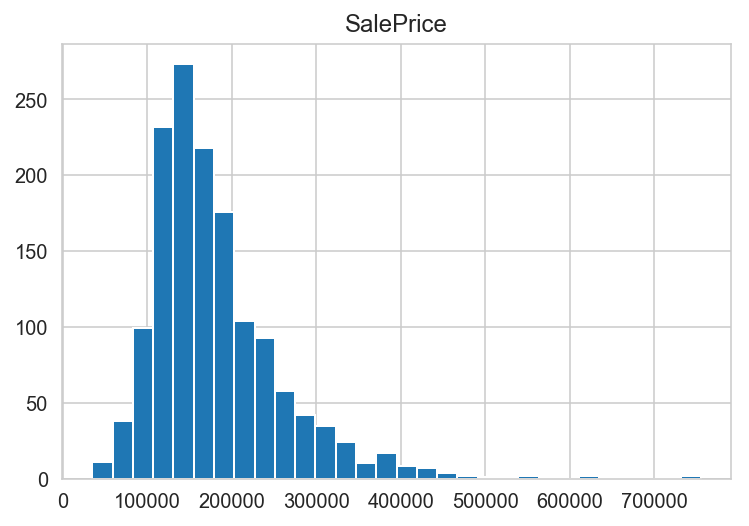

In [16]:
# SalePrice is right skewed. We need to log transform it. 
house[["SalePrice"]].hist(bins=30)

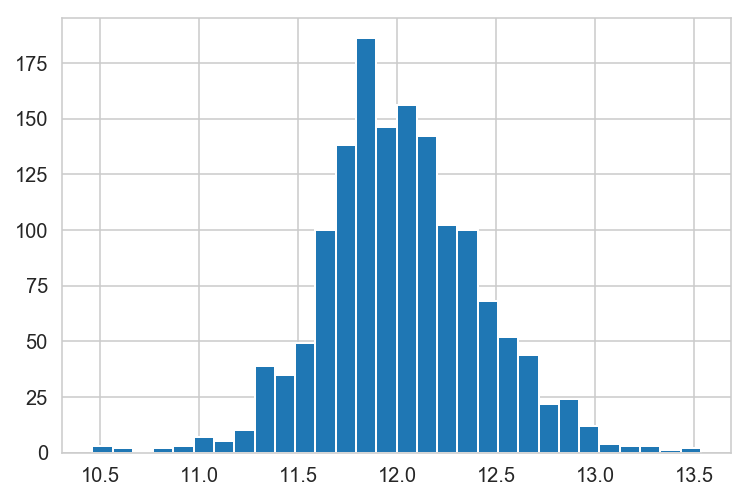

In [17]:
# Apply Log to normalise 'Saleprice' from its right skewness
house['SalePrice_log'] = np.log1p(house[["SalePrice"]])
house['SalePrice_log'] .hist(bins=30)

In [18]:
# Check for columns with numerical data types
print(house.get_dtype_counts())
house.dtypes[house.dtypes != "object"]

float64     4
int64      35
object     43
dtype: int64


Id                 int64
MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars         int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
SalePrice          int64
SalePrice_log    float64
dtype: object

In [19]:
# Check columns with strings or objects data types - for feature engineering, dummy variables, etc, later on

house.dtypes[house.dtypes == "object"]

MSZoning         object
Street           object
Alley            object
LotShape         object
LandContour      object
Utilities        object
LotConfig        object
LandSlope        object
Neighborhood     object
Condition1       object
Condition2       object
BldgType         object
HouseStyle       object
RoofStyle        object
RoofMatl         object
Exterior1st      object
Exterior2nd      object
MasVnrType       object
ExterQual        object
ExterCond        object
Foundation       object
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
BsmtFinType2     object
Heating          object
HeatingQC        object
CentralAir       object
Electrical       object
KitchenQual      object
Functional       object
FireplaceQu      object
GarageType       object
GarageFinish     object
GarageQual       object
GarageCond       object
PavedDrive       object
PoolQC           object
Fence            object
MiscFeature      object
SaleType        

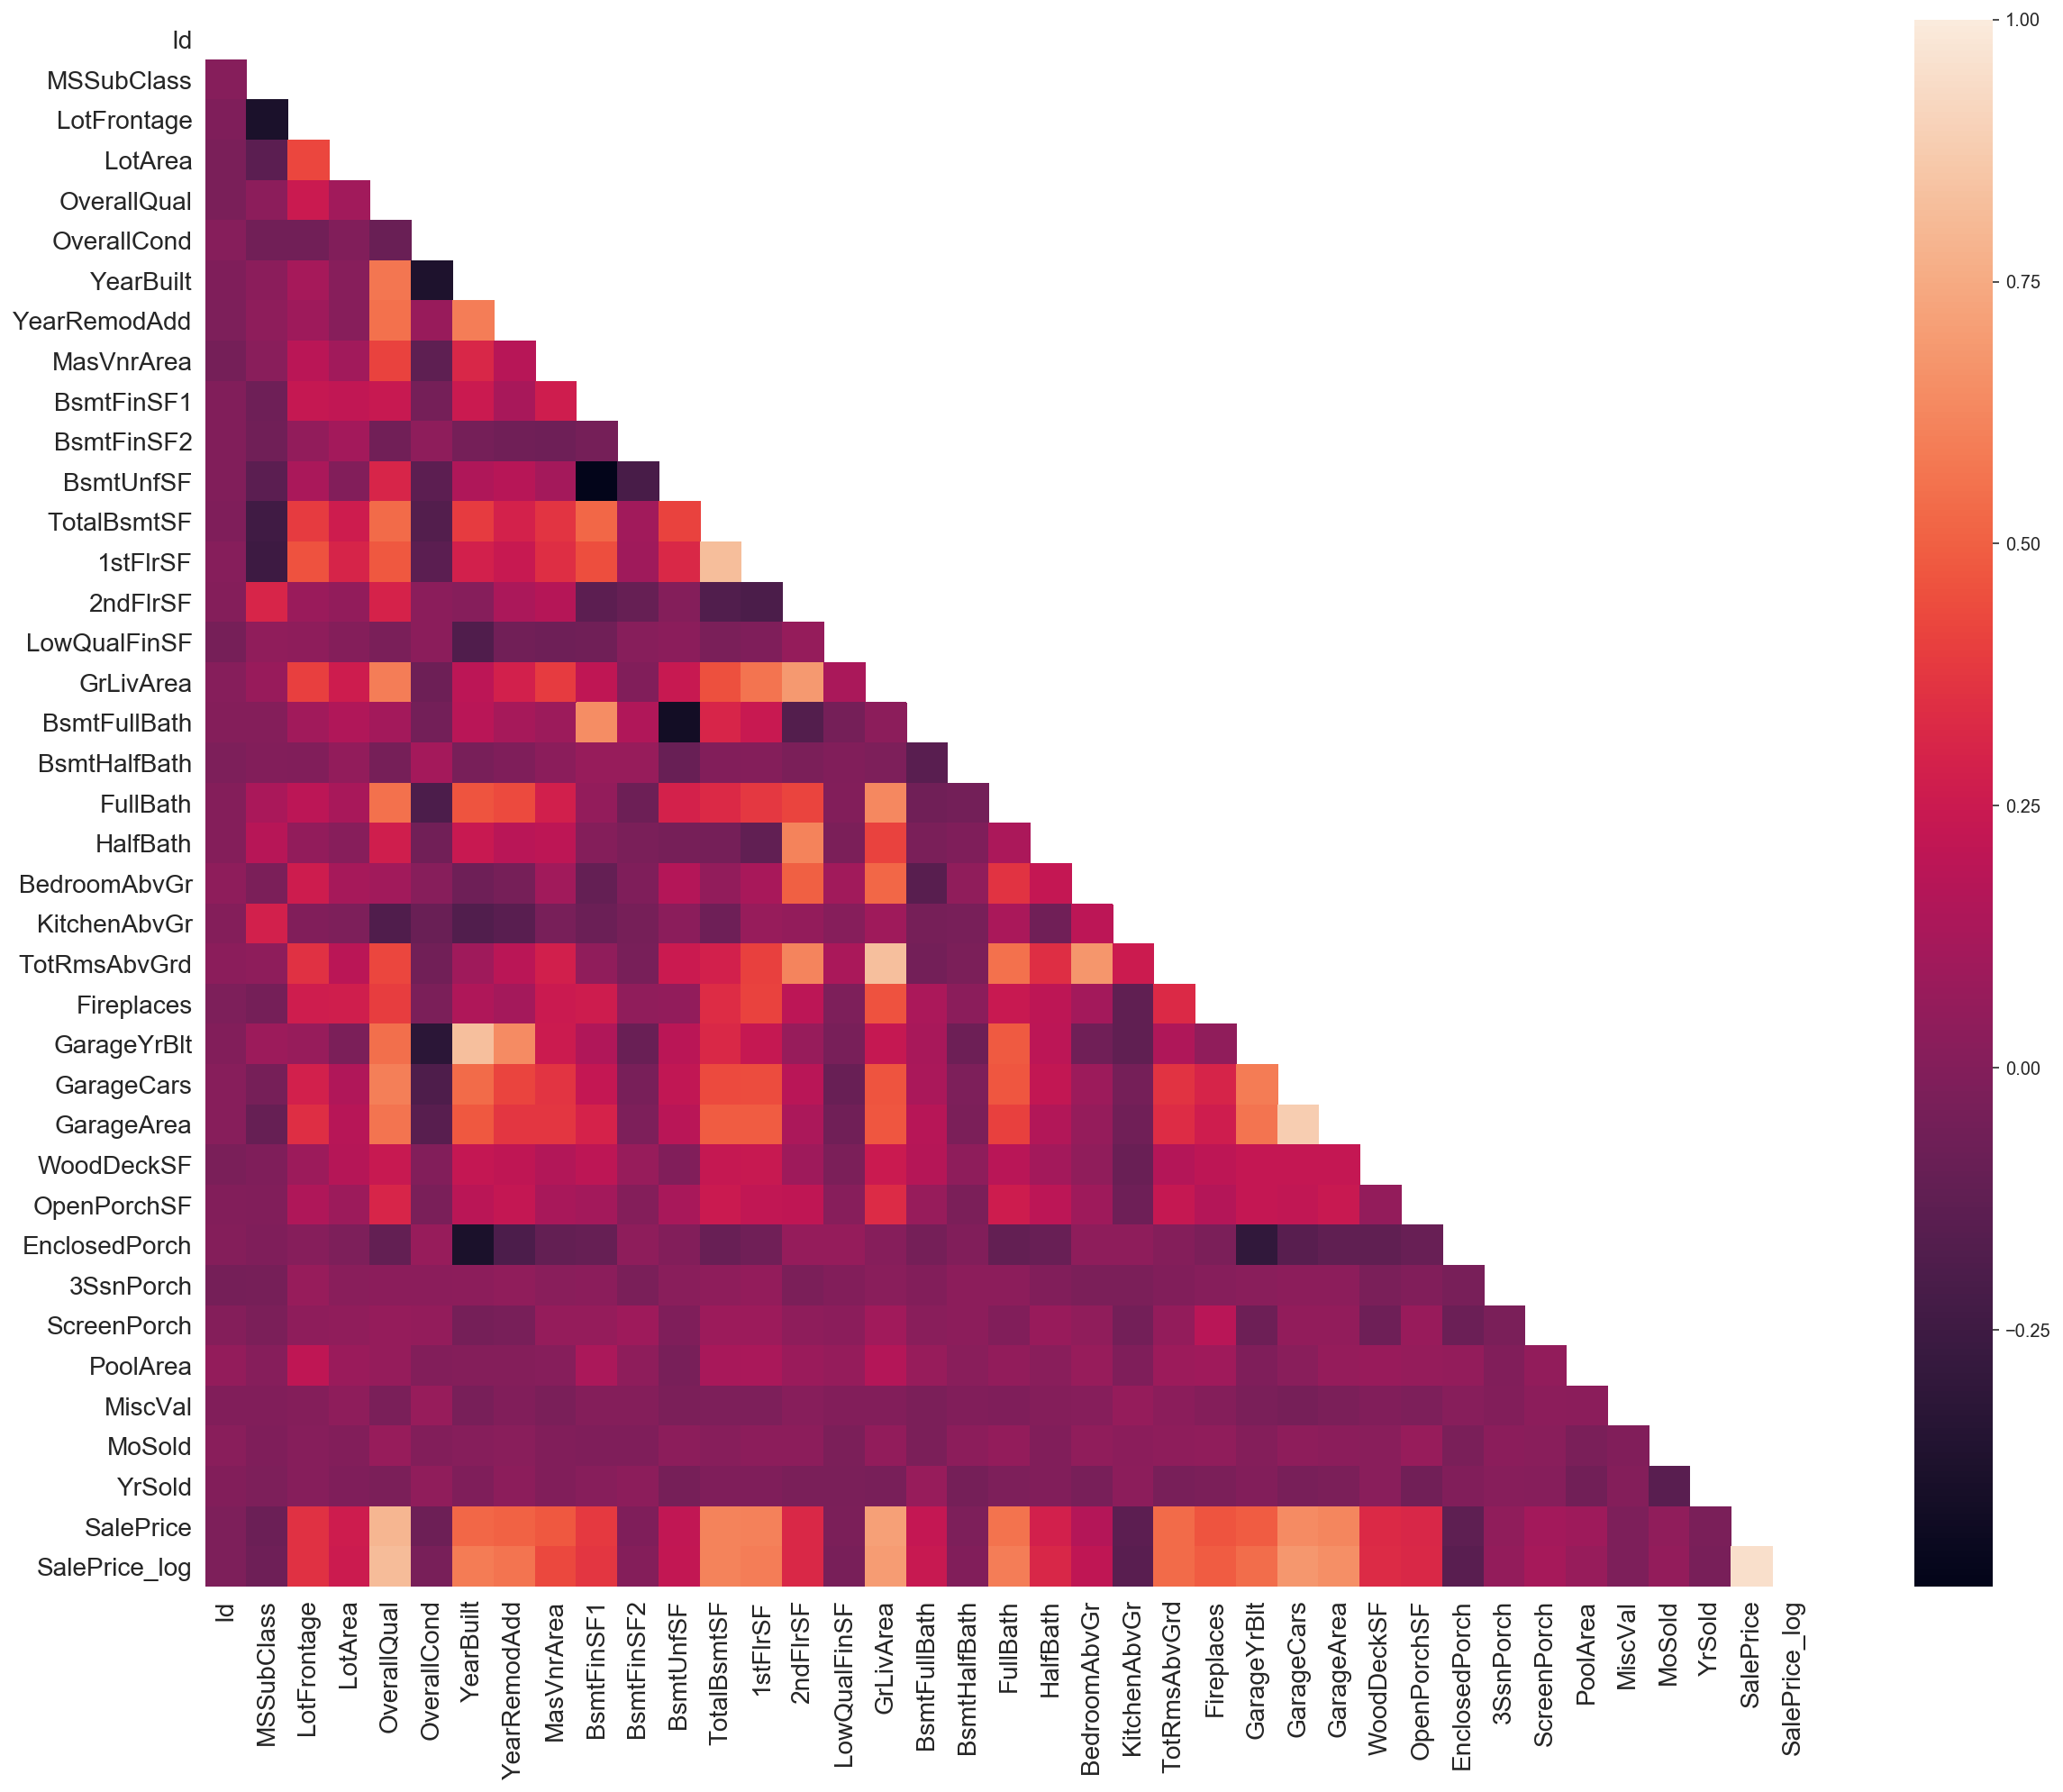

In [20]:
# Look at correlation between the variables.
fix, ax = plt.subplots(figsize=(20,16))
mask = np.zeros_like(house.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(house.corr(), mask=mask, ax=ax)
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)
plt.show()

In [21]:
# Correlation Matrix for SalePrice vs other columns
house.corr()['SalePrice_log'].sort_values(ascending=False)

SalePrice_log    1.000000
SalePrice        0.948374
OverallQual      0.817185
GrLivArea        0.700927
GarageCars       0.680625
GarageArea       0.650888
TotalBsmtSF      0.612134
1stFlrSF         0.596981
FullBath         0.594771
YearBuilt        0.586570
YearRemodAdd     0.565608
GarageYrBlt      0.541073
TotRmsAbvGrd     0.534422
Fireplaces       0.489450
MasVnrArea       0.430809
BsmtFinSF1       0.372023
LotFrontage      0.355879
WoodDeckSF       0.334135
OpenPorchSF      0.321053
2ndFlrSF         0.319300
HalfBath         0.313982
LotArea          0.257320
BsmtFullBath     0.236224
BsmtUnfSF        0.221985
BedroomAbvGr     0.209043
ScreenPorch      0.121208
PoolArea         0.069798
MoSold           0.057330
3SsnPorch        0.054900
BsmtFinSF2       0.004832
BsmtHalfBath    -0.005149
Id              -0.017942
MiscVal         -0.020021
OverallCond     -0.036868
YrSold          -0.037263
LowQualFinSF    -0.037963
MSSubClass      -0.073959
KitchenAbvGr    -0.147548
EnclosedPorc

##### Following features are the top 5 highest correlated features with SalePrice:
    
    1. OverallQual  -  Rates the overall material and finish of the house
    2. GrLivArea    -  Above grade (ground) living area square feet
    3. GarageCars   -  Size of garage in car capacity
    4. GarageArea   -  Size of garage in square feet
    5. TotalBsmtSF  -  Total square feet of basement area
    
    # As OverallQual and GrLivArea is the most correlated feature to SalePrice, will pick it as a the baseline regression model

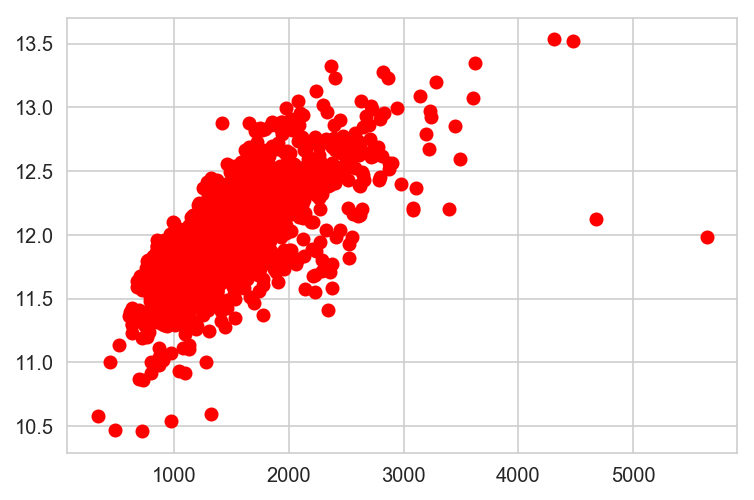

In [22]:
plt.scatter(house['GrLivArea'],y=house['SalePrice_log'],color='red')

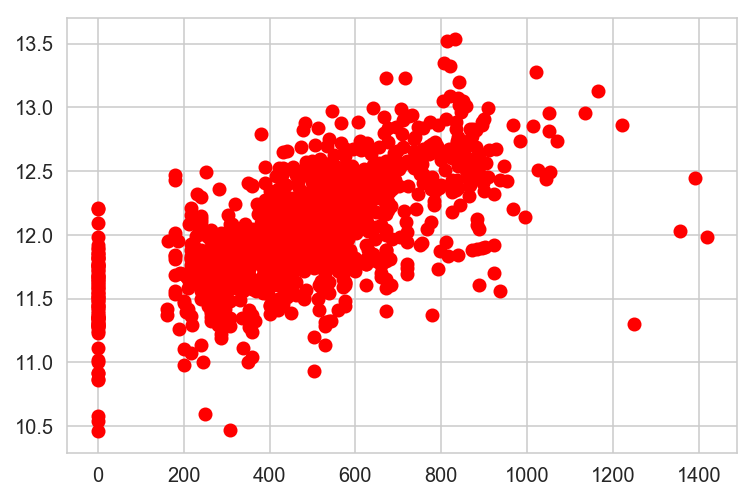

In [23]:
plt.scatter(house['GarageArea'],y=house['SalePrice_log'],color='red')

In [24]:
# Replacing MSSubClass into their respective values for dummy creation
house = house.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"}})

In [25]:
# Drop columns like "quality", "condition" and irrelevant columns for this section. 
# Quality and condition are renovatable features for 2nd question.

# df = house.drop(columns=\
#                          ['PoolQC','HeatingQC','FireplaceQu','KitchenQual','GarageQual','GarageCond',\
#                           'GarageFinish','OverallQual','OverallCond','ExterQual', 'ExterCond',\
#                           'Exterior1st','Exterior2nd','BsmtQual','BsmtCond',\
#                           'RoofStyle','RoofMatl','Electrical'], inplace=False)

In [26]:
# Remove any houses that are not residential from the dataset.
non_residential = df[df["MSZoning"].isin(['C (all)'])]
df = house.drop(index=non_residential.index)
df.drop(columns=["Id"], axis=1, inplace=True)   # Drop Id column

In [27]:
df.shape

(1450, 81)

In [28]:
df.dtypes[df.dtypes == "object"]

MSSubClass       object
MSZoning         object
Street           object
Alley            object
LotShape         object
LandContour      object
Utilities        object
LotConfig        object
LandSlope        object
Neighborhood     object
Condition1       object
Condition2       object
BldgType         object
HouseStyle       object
RoofStyle        object
RoofMatl         object
Exterior1st      object
Exterior2nd      object
MasVnrType       object
ExterQual        object
ExterCond        object
Foundation       object
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
BsmtFinType2     object
Heating          object
HeatingQC        object
CentralAir       object
Electrical       object
KitchenQual      object
Functional       object
FireplaceQu      object
GarageType       object
GarageFinish     object
GarageQual       object
GarageCond       object
PavedDrive       object
PoolQC           object
Fence            object
MiscFeature     

##### *** 3.Identify fixed features that can predict price

In [29]:
# Examine the non-renovatable features of a home to estimate home value

cols = ['GrLivArea','TotalBsmtSF',"TotRmsAbvGrd","GarageArea","GarageYrBlt","BsmtFinSF1","BsmtFinSF2",
        "BsmtUnfSF","BsmtFullBath",'LowQualFinSF',"1stFlrSF","2ndFlrSF","FullBath","YearRemodAdd","MasVnrArea","Fireplaces",
        "LotFrontage","OpenPorchSF","WoodDeckSF","LotArea",'BedroomAbvGr','KitchenAbvGr',"YrSold"]

dummies = pd.get_dummies(df[['MSZoning','Neighborhood','BldgType','LotShape','LotConfig','LandContour','LandSlope','Street','HouseStyle','Foundation']])

df1 = pd.concat([df[cols],dummies,], axis=1)

# df1.dtypes[df1.dtypes != "object"]

##### *** 4. Train a model on pre-2010 data and evaluate its performance on the 2010 house

In [30]:
df1.columns

Index(['GrLivArea', 'TotalBsmtSF', 'TotRmsAbvGrd', 'GarageArea', 'GarageYrBlt',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'BsmtFullBath', 'LowQualFinSF',
       '1stFlrSF', '2ndFlrSF', 'FullBath', 'YearRemodAdd', 'MasVnrArea',
       'Fireplaces', 'LotFrontage', 'OpenPorchSF', 'WoodDeckSF', 'LotArea',
       'BedroomAbvGr', 'KitchenAbvGr', 'YrSold', 'MSZoning_FV', 'MSZoning_RH',
       'MSZoning_RL', 'MSZoning_RM', 'Neighborhood_Blmngtn',
       'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide',
       'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor',
       'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_IDOTRR',
       'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes',
       'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU',
       'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst',
      

In [31]:
# Examine the non-renovatable features of a home to estimate home value

df1.isnull().sum().sort_values(ascending=False)

LotFrontage             259
GarageYrBlt              79
MasVnrArea                8
Foundation_Wood           0
Neighborhood_CollgCr      0
MSZoning_RL               0
MSZoning_RM               0
Neighborhood_Blmngtn      0
Neighborhood_Blueste      0
Neighborhood_BrDale       0
Neighborhood_BrkSide      0
Neighborhood_ClearCr      0
Neighborhood_Crawfor      0
MSZoning_FV               0
Neighborhood_Edwards      0
Neighborhood_Gilbert      0
Neighborhood_IDOTRR       0
Neighborhood_MeadowV      0
Neighborhood_Mitchel      0
Neighborhood_NAmes        0
Neighborhood_NPkVill      0
Neighborhood_NWAmes       0
MSZoning_RH               0
KitchenAbvGr              0
YrSold                    0
Neighborhood_NridgHt      0
TotalBsmtSF               0
TotRmsAbvGrd              0
GarageArea                0
BsmtFinSF1                0
                       ... 
HouseStyle_2Story         0
HouseStyle_SFoyer         0
HouseStyle_SLvl           0
Foundation_BrkTil         0
Foundation_CBlock   

In [32]:
df1["LotFrontage"].fillna(df1["LotFrontage"].median(), inplace=True)
df1["GarageYrBlt"].fillna(df1['GarageYrBlt'].median(), inplace=True)
df1["MasVnrArea"].fillna(0, inplace=True)             

In [33]:
# Setting up the target and predictor matrix
df1["SalePrice_Log"] = house['SalePrice_log'] 

y_train = df1[df1['YrSold']<2010] ['SalePrice_Log']
y_test = df1[df1['YrSold']==2010] ['SalePrice_Log']

df1 = df1.drop(columns=['SalePrice_Log'])

X_train = df1[df1['YrSold']<2010]
X_test = df1[df1['YrSold']==2010]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1278, 89)
(172, 89)
(1278,)
(172,)


In [34]:
# Standardise the predictor data

ss1 = StandardScaler()
X_train = ss1.fit_transform(X_train)
X_test = ss1.transform(X_test)

In [35]:
# Using sklearn module

model = LinearRegression()
lm = model.fit(X_train, y_train)

y_pred = lm.predict(X_test)
lm_resid = y_test - y_pred

print("Model Score on Train Set:", model.score(X_train, y_train))
print("Model Score on Test Set:", model.score(X_test, y_test),'\n')

scores = cross_val_score(lm, X_train, y_train, cv=10)
print(scores)

print("Mean:", np.mean(scores), "Std:", np.std(scores))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

Model Score on Train Set: 0.860344998294484
Model Score on Test Set: 0.8677496483045358 

[0.88147854 0.86800897 0.86033917 0.79715183 0.84261072 0.87221314
 0.85310324 0.81257758 0.4864566  0.8288666 ]
Mean: 0.8102806382317626 Std: 0.11090865154368514
RMSE: 0.1431671104263025


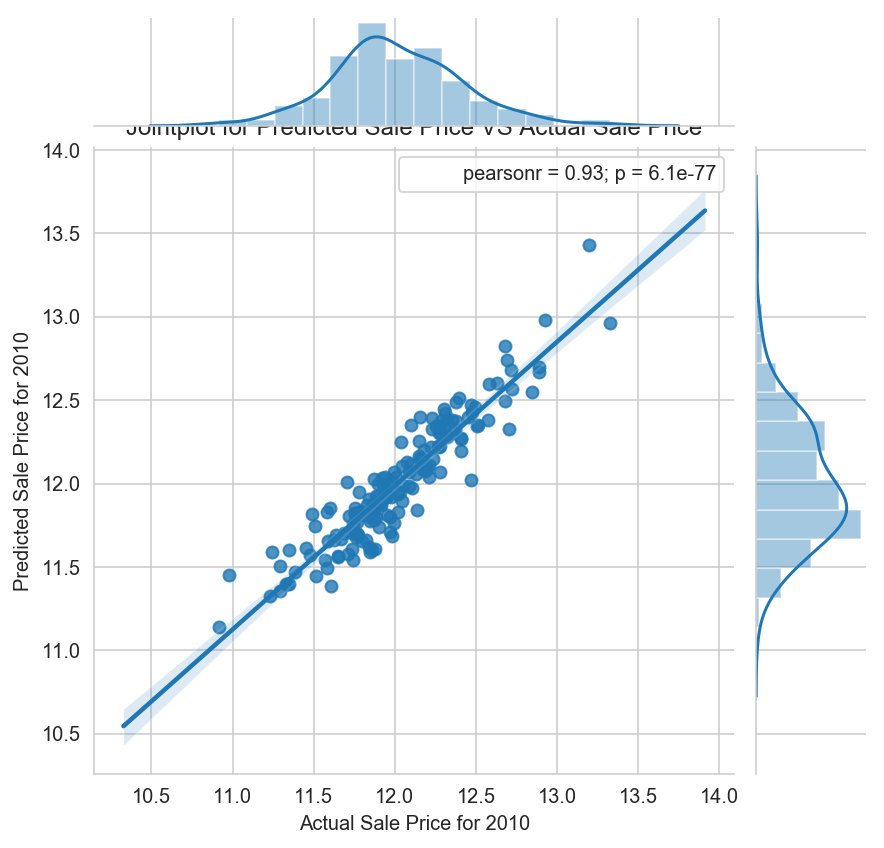

In [36]:
sns.jointplot(x=y_test, y=lm.predict(X_test), kind="reg").annotate(stats.pearsonr)
plt.title("Jointplot for Predicted Sale Price VS Actual Sale Price")
plt.xlabel("Actual Sale Price for 2010")
plt.ylabel("Predicted Sale Price for 2010")
plt.show()

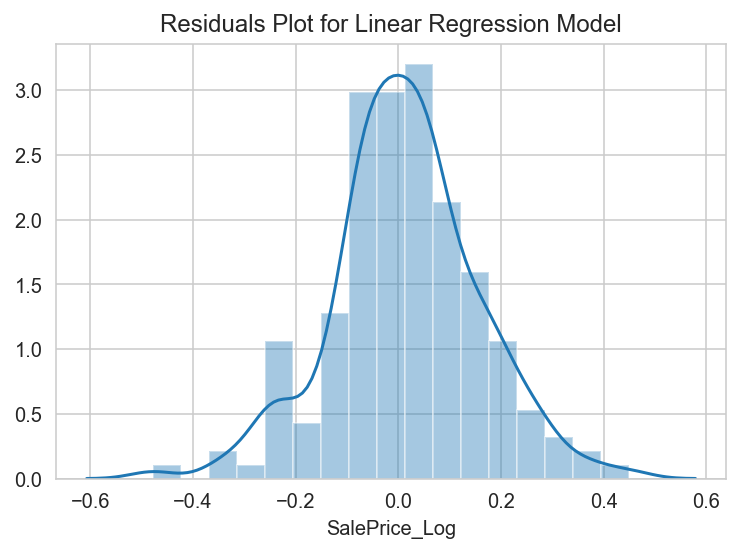

In [37]:
sns.distplot(lm_resid)
plt.title("Residuals Plot for Linear Regression Model")
plt.show()

In [38]:
print(lm.coef_)
print(lm.intercept_)

[-7.46840415e+07  4.14634904e+10  2.62178183e-02  5.08255735e-02
 -1.23169050e-02 -4.30527722e+10 -1.45883295e+10 -4.18533699e+10
  2.48701349e-02  6.89621603e+06  5.47692869e+07  6.18962980e+07
  2.44057178e-02  6.49042130e-02  5.30433655e-03  3.94577980e-02
 -1.17197037e-02  1.09195709e-02  1.46770477e-02  1.88274384e-02
  1.19590759e-03 -3.81212234e-02 -6.19745255e-03  5.23428770e+10
  2.81936951e+10  1.03226313e+11  9.11787983e+10  1.00864203e+09
  3.58581374e+08  9.77000300e+08  1.85685080e+09  1.23140746e+09
  2.80640599e+09  1.72472781e+09  2.30904992e+09  2.10524355e+09
  1.25629876e+09  9.44245551e+08  1.67199582e+09  3.24125291e+09
  6.69528684e+08  2.00756987e+09  1.45981238e+09  2.05014741e+09
  2.41380084e+09  1.17992269e+09  1.88817092e+09  1.68978582e+09
  2.17162742e+09  1.12590750e+09  1.43876226e+09  8.37976891e+08
 -5.16574169e+09 -1.94177237e+09 -2.58428599e+09 -2.38152650e+09
 -3.74823902e+09 -5.21460216e+10 -1.79811914e+10 -9.70752470e+09
 -5.33098940e+10  1.36900

In [77]:
# Using statmod module

X_train2 = np.concatenate([X_train, np.ones((X_train.shape[0],1))], axis=1)
model = sm.OLS(y_train, X_train2).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          SalePrice_Log   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     96.01
Date:                Fri, 18 Jan 2019   Prob (F-statistic):               0.00
Time:                        03:05:21   Log-Likelihood:                 643.52
No. Observations:                1278   AIC:                            -1131.
Df Residuals:                    1200   BIC:                            -729.1
Df Model:                          77                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0663      0.007      9.230      0.000       0.052       0.080
x2             0.0254      0.007      3.641      0.000       0.012       0.039
x3             0.0262      0.010      2.622      0.009       0.007       0.046
x4             0.0508      0.006      8.172      0.000       0.039       0.063
x5            -0.0123      0.008     -1.587      0.113      -0.028       0.003
x6             0.0189      0.005      3.780      0.000       0.009       0.029
x7             0.0057      0.004      1.289      0.198      -0.003       0.014
x8             0.0037      0.005      0.813      0.416      -0.005       0.013
x9             0.0249      0.006      4.018      0.000       0.013       0.037
x10           -0.0034      0.006     -0.586      0.558      -0.015       0.008
x11            0.0277      0.009      3.088      0.002       0.010       0.045
x12            0.0559      0.009      6.017      0.000       0.038       0.074
x13            0.0244      0.007      3.439      0.001       0.010       0.038
x14            0.0649      0.006     10.449      0.000       0.053       0.077
x15            0.0053      0.005      0.989      0.323      -0.005       0.016
x16            0.0394      0.006      7.129      0.000       0.029       0.050
x17           -0.0118      0.006     -1.960      0.050      -0.024    1.47e-05
x18            0.0109      0.005      2.208      0.027       0.001       0.021
x19            0.0147      0.005      3.090      0.002       0.005       0.024
x20            0.0189      0.007      2.873      0.004       0.006       0.032
x21            0.0012      0.007      0.169      0.866      -0.012       0.015
x22           -0.0381      0.007     -5.102      0.000      -0.053      -0.023
x23           -0.0062      0.004     -1.423      0.155      -0.015       0.002
x24           -0.0012      0.008     -0.157      0.875      -0.016       0.014
x25           -0.0062      0.005     -1.366      0.172      -0.015       0.003
x26           -0.0004      0.004     -0.094      0.925      -0.009       0.008
x27            0.0030      0.005      0.555      0.579      -0.008       0.014
x28            0.0095      0.005      1.886      0.060      -0.000       0.019
x29           -0.0010      0.004     -0.232      0.816      -0.010       0.008
x30           -0.0080      0.005     -1.460      0.145      -0.019       0.003
x31           -0.0184      0.005     -3.481      0.001      -0.029      -0.008
x32           -0.0020      0.005     -0.415      0.678      -0.012       0.008
x33            0.0129      0.005      2.784      0.005       0.004       0.022
x34            0.0199      0.005      4.178      0.000       0.011       0.029
x35           -0.0375      0.004     -8.685      0.000      -0.046      -0.029
x36            0.0050      0.005      0.977      0.329      -0.005       0.015
x3

In [40]:
# Try using SelectKBest to select best features.

from sklearn.feature_selection import SelectKBest, chi2, f_regression

# Define function that takes in the number of features to choose and returns the list of best features
def choose_features(n, x_train, y_train):
    skb = SelectKBest(f_regression, k=n)
    skb.fit(x_train, y_train)
    best_features = pd.DataFrame([x_train.columns, list(skb.scores_)],\
                                 index=['feature','f_score']).T.sort_values('f_score', ascending=False)
    return list(best_features[0:n]['feature'])


# Define function that takes the list of features and returns the cross validation score
# and score of model on test data
def score_model(features, x_train, y_train, x_test, y_test):
    select_x_train = x_train[features]
    select_x_test = x_test[features]
    
    lr = LinearRegression()
    mean_score = np.mean(cross_val_score(lr, X=select_x_train, y=y_train, cv=5, n_jobs=-1, verbose=1))
    
    lr.fit(select_x_train, y_train)
    test_score = lr.score(select_x_test, y_test)
    return mean_score, test_score

X_train = pd.DataFrame(X_train, columns=df1.columns)
X_test = pd.DataFrame(X_test, columns=df1.columns)

In [41]:
#*************************************************************************
#                        High CPU Consumption
#*************************************************************************

# Iterate through the number of features to record the scores
n_feat = range(1, len(X_train.columns)+1)
mean_score_list = []
test_score_list = []

for n in n_feat:
    feat_list = choose_features(n, X_train, y_train)
    mean_score, test_score = score_model(feat_list, X_train, y_train, X_test, y_test)
    mean_score_list.append(mean_score)
    test_score_list.append(test_score)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend Loky

In [42]:
print(np.mean(mean_score_list))
print(np.mean(test_score_list))

0.7856635871273014
0.8490830958160394


In [43]:
# Use predict to verify earlier score
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
print(r2_score(y_test,y_pred))
mean_squared_error(y_test,y_pred)

0.8677496483045358


0.020496821507817092

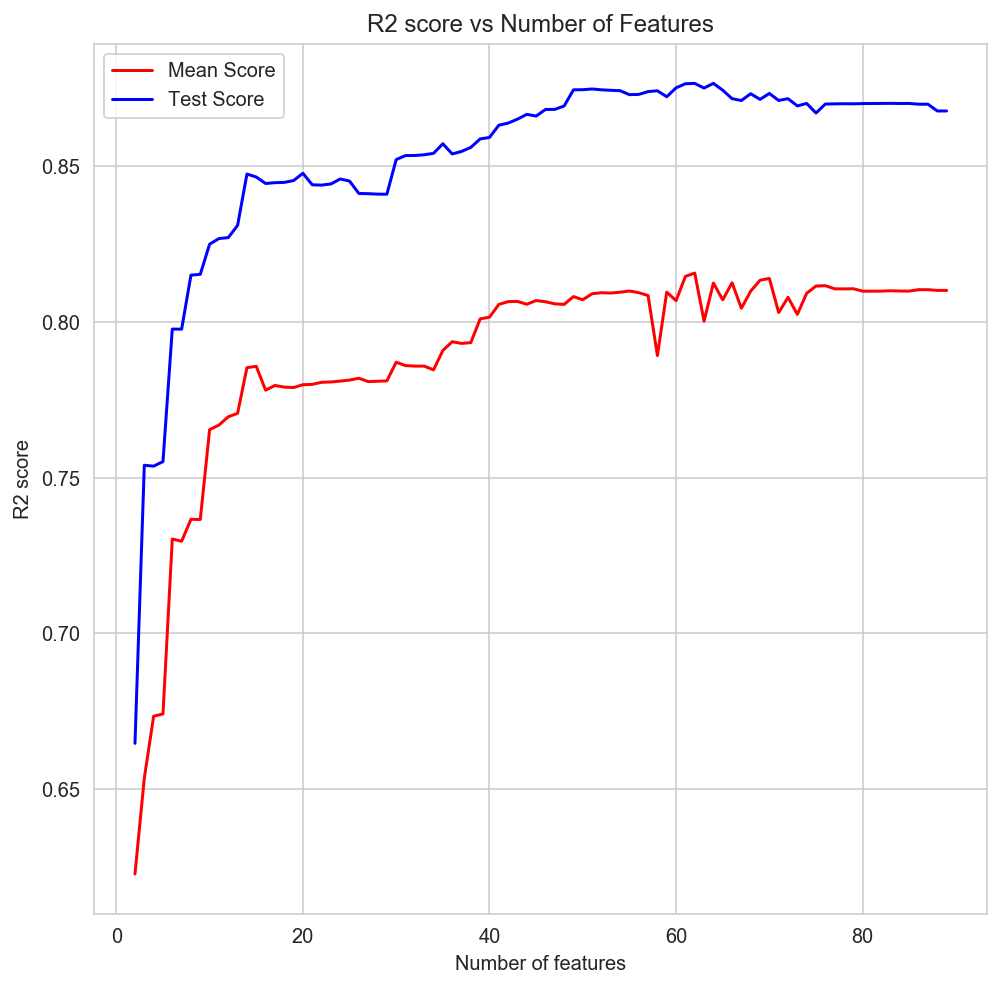

In [44]:
# Plot the R2 of test data vs number of features
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
ax1.plot(n_feat[1:90], mean_score_list[1:90], color='r', label='Mean Score')
ax1.plot(n_feat[1:90], test_score_list[1:90], color='b', label='Test Score')
plt.xlabel('Number of features')
plt.ylabel('R2 score')
plt.title('R2 score vs Number of Features')
plt.legend(loc=2)
plt.show()

From the above chart, we can observe that R2 score starts to get better when over 15 features or more. But it remains relatively flat even with more features which can be costly for computation. 
So optimal numbers of features should be around 15-20.  

*** Using Ridge, Lasso and ElasticNet to regularise some features to see if there is any improvement in performance.

##### ****** Ridge ******


In [45]:
###  Find best alpha using RidgeCV
ridge_alphas = np.logspace(-2, 7, 50)
optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(X_train, y_train)
print(optimal_ridge.alpha_)

###  Cross-validate the Ridge regression R2  with the optimal alpha
ridge = Ridge(alpha=optimal_ridge.alpha_)
ridge_scores = cross_val_score(ridge, X_test, y_test, cv=8)
print(ridge_scores)
print(np.mean(ridge_scores))

255.95479226995386
[0.85275429 0.76783255 0.87056537 0.75261063 0.87189729 0.79603167
 0.8394607  0.77488605]
0.8157548175891371


###### Ridge Regression model's mean score is 0.8157. It is quite close to the Linear Regression model with a score of 0.8102. Not much improvement. Let try Lasso next.

##### ****** Lasso ******

In [46]:
###  Find best alpha using LassoCV
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(X_train, y_train)
print(optimal_lasso.alpha_)

###  Cross-validate the Lasso regression  R2  with the optimal alpha
lasso = Lasso(alpha=optimal_lasso.alpha_)
lasso_scores = cross_val_score(lasso, X_test, y_test, cv=8)

print(lasso_scores)
print(np.mean(lasso_scores)) 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.0037175970126716567
[0.86090899 0.7550128  0.92113788 0.79910529 0.8977132  0.87842516
 0.87998247 0.82903605]
0.8526652293716912


................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.1s finished


##### Lasso Regression scores is 0.8526.  This model is better than Ridge model of 0.8157.

In [47]:
###  Look at the coefficients for variables in Lasso

lasso.fit(X_test, y_test)
y_pred_lasso = lasso.predict(X_test)

lasso_coefs = pd.DataFrame({'variable':df1.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})
lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs

,variable,coef,abs_coef
0,GrLivArea,0.103346,0.103346
3,GarageArea,0.076179,0.076179
1,TotalBsmtSF,0.063559,0.063559
33,Neighborhood_Crawfor,0.053495,0.053495
4,GarageYrBlt,0.048077,0.048077
85,Foundation_PConc,0.044912,0.044912
34,Neighborhood_Edwards,-0.037447,0.037447
31,Neighborhood_ClearCr,0.034207,0.034207
13,YearRemodAdd,0.033809,0.033809
26,MSZoning_RM,-0.030368,0.030368


For fixed (non-renovatable) feature, the Lasso model's coefficents picked "Above ground living area", "Garage area" and "Total basement area" are top 3 most influencing relationship on house' sale price. 

In [48]:
from sklearn.linear_model import Lasso

lasso = Lasso()
parameters = {'alpha':[1e-04,2e-03,0.01,0.1,0.5,0.7,1,2,5], 
              'normalize':[True,False], 
              'tol':[1e-07,1e-06,2e-05,5e-05,1e-04,5e-04,2e-03,1e-02]}

gridsearch_lasso = GridSearchCV(lasso, parameters, cv=5, verbose=1)
gridsearch_lasso.fit(X_train, y_train)

print(gridsearch_lasso.best_score_)
print(gridsearch_lasso.best_estimator_.get_params())

y_pred_lasso1 = gridsearch_lasso.best_estimator_.predict(X_test).reshape(-1,1)

mse_lasso = mean_squared_error(y_test, y_pred_lasso1)
rmse_lasso = np.sqrt(mse_lasso)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 144 candidates, totalling 720 fits
0.8137489569445872
{'alpha': 0.0001, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'normalize': True, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.01, 'warm_start': False}


[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:    3.3s finished


In [49]:
scores_lasso = cross_val_score(lasso, X_train, y_train, cv=5)
print(scores_lasso)
print("Mean:", np.mean(scores_lasso), "Std:", np.std(scores_lasso))
print("RMSE:", rmse_lasso)

[-6.57758181e-03 -9.96071483e-05 -3.88231286e-03 -1.92612100e-02
 -3.60418668e-05]
Mean: -0.005971350733880864 Std: 0.007086003361936906
RMSE: 0.1378102510849206


In [50]:
#####***** For Q2 below -> Residual No. 1 - For Lasso model  *****######

resid1 = (np.exp(y_test.values) - np.exp(y_pred_lasso)).sum()
resid1

270163.56735536153

##### ****** ElasticNet ******

In [51]:
###  Find best alpha and l1_ratio using ElasticNetCV
l1_ratios = np.linspace(0.01, 1.0, 25)

optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=30, cv=10)
optimal_enet.fit(X_train, y_train)
print(optimal_enet.alpha_)
print(optimal_enet.l1_ratio_)

# Build elastic net regression predicting shares from the five features.
# Initially cross validated with 10 folds but it produced a poorer R^2 result.

enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)
enet_scores = cross_val_score(enet, X_test, y_test, cv=8)

print(enet_scores)
print(np.mean(enet_scores))

0.1851774060924876
0.01
[0.88157428 0.76987291 0.91315314 0.80364171 0.89688281 0.89269525
 0.87026189 0.83060082]
0.8573353522592413


###### ElasticNet Regression scores is slightly better at 0.8573. It performed slightly better than Lasso Regression of 0.8526. 

##### ****Use GridSearch on ElasticNet

In [52]:
from sklearn.linear_model import ElasticNetCV

elasticnet = ElasticNetCV()
parameters = {'l1_ratio':[1e-03,0.01,0.1,0.2,0.5,0.8,1],
              'normalize':[True,False],
              'tol':[1e-06,1e-05,5e-05,1e-04,5e-04,1e-03]}
gridsearch_elasticnet = GridSearchCV(elasticnet, parameters, cv=3, verbose=1)
gridsearch_elasticnet.fit(X_train, y_train.values.ravel())
print(gridsearch_elasticnet.best_score_)
print(gridsearch_elasticnet.best_estimator_.get_params())

y_pred_elasticnet = gridsearch_elasticnet.best_estimator_.predict(X_test).reshape(-1,1)
mse_elasticnet = mean_squared_error(y_test, y_pred_elasticnet)
rmse_elasticnet = np.sqrt(mse_elasticnet)

scores = cross_val_score(elasticnet, X_test, y_test.values.ravel(), cv=5)
print(scores)
print("Mean:", np.mean(scores), "Std:", np.std(scores))
print("RMSE:", rmse_elasticnet)

Fitting 3 folds for each of 84 candidates, totalling 252 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 252 out of 252 | elapsed:   18.4s finished


0.812351559024031
{'alphas': None, 'copy_X': True, 'cv': 'warn', 'eps': 0.001, 'fit_intercept': True, 'l1_ratio': 0.1, 'max_iter': 1000, 'n_alphas': 100, 'n_jobs': None, 'normalize': False, 'positive': False, 'precompute': 'auto', 'random_state': None, 'selection': 'cyclic', 'tol': 1e-06, 'verbose': 0}
[0.84119201 0.86432463 0.89048897 0.89178367 0.85052536]
Mean: 0.8676629264867856 Std: 0.020534792041173703
RMSE: 0.13895098007774945


######  GridSearch has found the optimal parameters for ElasticNet which improves the score to 0.8676.

### *** Use Feature selection - RFECV 

In [53]:
# Use feature selection to identify relevant features

from sklearn.feature_selection import RFECV

rfe_lr = LinearRegression()
rfe1 = RFECV(rfe_lr, step=1, cv=10, n_jobs=-1, verbose=1)
rfe1.fit(X_train, y_train)

print('Number of features selected by RFE: {}'.format(rfe1.n_features_),'\n')
rfe1_list = X_train.columns[rfe1.support_]

print(rfe1_list,'\n')
print(rfe1.ranking_)

Fitting estimator with 89 features.
Fitting estimator with 88 features.
Fitting estimator with 87 features.
Fitting estimator with 86 features.
Fitting estimator with 85 features.
Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Number of features selected by RFE: 78 

Index(['GrLivArea', 'TotalBsmtSF', 'TotRmsAbvGrd', 'GarageArea', 'GarageYrBlt',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'BsmtFullBath', 'LowQualFinSF',
       '1stFlrSF', '2ndFlrSF', 'FullBath', 'YearRemodAdd', 'Fireplaces',
       'LotFrontage', 'OpenPorchSF', 'WoodDeckSF', 'LotArea', 'KitchenAbvGr',
       'YrSold', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RM',
       'Neighborhood_Blmngtn', 'Neighborhood_Blueste', 'Neighborhood_BrDale',
       'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr',
       'Neighborhood_Crawfor', 'N

In [54]:
# check score of model with the features selected by RFE

score_model(rfe1_list, X_train, y_train, X_test, y_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


(0.8118752180544926, 0.868018221764759)

##### RFE feature selection model selected 78 features out of 89.
##### Using the list of features from RFE helped a slight improvement in R2 score to 0.8680.

### *** Feature Engineering:  

In [55]:
#  Feature 1 - Total Living Area Square Foot 
#  This is derived from GrLivArea "and" TotalBsmtSF "and" GarageArea "less" LowQualFinSF.

df['TotalLivingSF'] = df['GrLivArea'] + df['TotalBsmtSF'] + df['GarageArea'] - df['LowQualFinSF']

#  Feature 2 - Total Outdoor Area Square Foot
#  This is derived from OpenPorchSF "and" WoodDeckSF "and" LotFrontage 

df['OutdoorAreaSF'] = df['OpenPorchSF'] + df['WoodDeckSF'] + df['LotFrontage']

cols_featured_eng = ['TotalLivingSF','OutdoorAreaSF',"TotRmsAbvGrd","GarageYrBlt","BsmtFinSF1","BsmtFinSF2","BsmtUnfSF",
                     "BsmtFullBath","1stFlrSF","2ndFlrSF","FullBath","YearRemodAdd","MasVnrArea","Fireplaces","LotArea",
                     'BedroomAbvGr','KitchenAbvGr',"YrSold"]

dummies_featured_eng = pd.get_dummies(df[['MSZoning','Neighborhood','BldgType','LotShape','LotConfig','LandContour',
                                          'LandSlope','Street','HouseStyle','Foundation']])

df2 = pd.concat([df[cols_featured_eng],dummies_featured_eng], axis=1)

df2["OutdoorAreaSF"].fillna(df2["OutdoorAreaSF"].median(), inplace=True)
df2["GarageYrBlt"].fillna(df2['GarageYrBlt'].median(), inplace=True)
df2["MasVnrArea"].fillna(0, inplace=True)  

# print(df2.isnull().sum().sort_values(ascending=False))

In [56]:
df2["SalePrice_Log"] = house['SalePrice_log'] 

y_train2 = df2[df2['YrSold']<2010] ['SalePrice_Log']
y_test2 = df2[df2['YrSold']==2010] ['SalePrice_Log']

df2 = df2.drop(columns=['SalePrice_Log'])

X_train2 = df2[df2['YrSold']<2010]
X_test2 = df2[df2['YrSold']==2010]

df2 = df2.drop(columns=['YrSold'])

ss2 = StandardScaler()
X_train2 = ss2.fit_transform(X_train2)
X_test2 = ss2.transform(X_test2)

model = LinearRegression()
lm = model.fit(X_train2, y_train2)
y_pred2 = lm.predict(X_test2)
lm_resid2 = y_test2 - y_pred2
print("Model Score on Train Set:", model.score(X_train2, y_train2))
print("Model Score on Test Set:", model.score(X_test2, y_test2),'\n')
scores = cross_val_score(lm, X_train2, y_train2, cv=10)
print(scores)
print("Mean:", np.mean(scores), "Std:", np.std(scores))
print("RMSE:", np.sqrt(mean_squared_error(y_test2, y_pred2)))

Model Score on Train Set: 0.8593196455213795
Model Score on Test Set: 0.8721681324314199 

[0.88102393 0.87187317 0.85908436 0.80188658 0.84154668 0.87825967
 0.85399362 0.82412187 0.49654727 0.82105868]
Mean: 0.812939584624958 Std: 0.10836315364758464
RMSE: 0.14075518718805566


##### Feature engineering has marginally improved the original score of 0.8102 to 0.8129. 
##### More time requires to further research each every individual features in detail. 
##### This will help in better feature engineering

### Other Models

**1.Random Forest**

In [57]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 1000, random_state = 5)
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=5, verbose=0, warm_start=False)

In [58]:
print(cross_val_score(rf,X_test,y_test,cv=10,verbose=False).mean())

0.7725428996850858


In [59]:
from sklearn.model_selection import RandomizedSearchCV
rf_param={
    'criterion': ['mse'],
    'max_depth': [80],
    'max_features': ['auto'],
    'n_estimators': [1100,1200,1300],
    'min_samples_leaf': [2],
    'min_samples_split': [2]
}
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator=rf,param_distributions=rf_param,n_iter=5,cv=8,verbose=2,random_state=5,n_jobs=-1)
rf_random.fit(X_train,y_train)

Fitting 8 folds for each of 3 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  24 | elapsed:   28.4s remaining:   20.2s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   29.6s finished


RandomizedSearchCV(cv=8, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=5, n_jobs=-1,
          param_distributions={'criterion': ['mse'], 'max_depth': [80], 'max_features': ['auto'], 'n_estimators': [1100, 1200, 1300], 'min_samples_leaf': [2], 'min_samples_split': [2]},
          pre_dispatch='2*n_jobs', random_state=5, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [60]:
print(rf_random.best_score_)
print(rf_random.best_params_)
model=rf_random.best_estimator_
print(cross_val_score(model,X_test,y_test,cv=8,verbose=False).mean())

0.8407148517527169
{'n_estimators': 1200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 80, 'criterion': 'mse'}
0.7747759539976542


**2.PCA**

In [61]:
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDRegressor

n_list=[x for x in range(1,81,1)]
score_list=[]
for n in range(1,81,1):
    pca = PCA(n_components=n)
    pca.fit(X_train)
    X_train2 = pca.transform(X_train)
    X_test2 = pca.transform(X_test)
    sgd_reg = SGDRegressor()
    selector = RFECV(sgd_reg, step=1, cv=10,scoring='neg_mean_squared_error')
    selector = selector.fit(X_train2, y_train)
    score_list.append(selector.score(X_test2,y_test))
    
print(np.array(score_list).max())
score_list.index(np.array(score_list).max())+1

0.8891520233846334


37

#### ***PCA model's result of 0.8891 is the best R2 score across all the models in this project. 
#### This is followed closely by RFE feature selection model which has a score of 0.8680

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [62]:
cols_renovatable = ["OverallQual", "OverallCond",'Fireplaces','BsmtFullBath','WoodDeckSF','OpenPorchSF','EnclosedPorch',
                    '3SsnPorch','ScreenPorch','PoolArea','YrSold','BedroomAbvGr','KitchenAbvGr','FullBath','HalfBath']
df3 = df[cols_renovatable]

dummies_renovatable = pd.get_dummies(df[['Utilities','RoofStyle','RoofMatl','Exterior1st','Exterior2nd',\
          'MasVnrType','ExterQual','ExterCond','BsmtCond','BsmtFinType1','Fence',\
          'Heating','HeatingQC','CentralAir','Electrical','KitchenQual','Functional',\
          'FireplaceQu','GarageFinish','GarageQual','GarageCond','PavedDrive','PoolQC','MiscFeature']])

df3 = pd.concat([df3,dummies_renovatable], axis=1)

In [63]:
for item in ["OverallQual", "OverallCond"]:
    df3 = df3.join(pd.get_dummies(df3[item], prefix=item), on=df3.index)

In [64]:
df3 = df3.replace({"BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2,"TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},                       
                       "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2 ,"TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2 ,"TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4}})

In [65]:
print(df3.get_dtype_counts())
print(df3.columns)
print(df3.isnull().sum().sort_values(ascending=False))
print(df3.shape)

int64     15
uint8    150
dtype: int64
Index(['OverallQual', 'OverallCond', 'Fireplaces', 'BsmtFullBath',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea',
       ...
       'OverallQual_10', 'OverallCond_1', 'OverallCond_2', 'OverallCond_3',
       'OverallCond_4', 'OverallCond_5', 'OverallCond_6', 'OverallCond_7',
       'OverallCond_8', 'OverallCond_9'],
      dtype='object', length=165)
OverallCond_9          0
Exterior2nd_Wd Sdng    0
Exterior2nd_Stucco     0
Exterior2nd_Stone      0
Exterior2nd_Plywood    0
Exterior2nd_Other      0
Exterior2nd_MetalSd    0
Exterior2nd_ImStucc    0
Exterior2nd_HdBoard    0
Exterior2nd_CmentBd    0
Exterior2nd_CBlock     0
Exterior2nd_BrkFace    0
Exterior2nd_Brk Cmn    0
Exterior2nd_AsphShn    0
Exterior2nd_AsbShng    0
Exterior1st_WdShing    0
Exterior1st_Wd Sdng    0
Exterior1st_VinylSd    0
Exterior1st_Stucco     0
Exterior2nd_VinylSd    0
Exterior2nd_Wd Shng    0
BsmtFinType1_GLQ       0
MasVnr

In [66]:
df3["SalePrice_Log"] = house['SalePrice_log'] 

y_train3 = df3[df3['YrSold']<2010] ['SalePrice_Log']
y_test3 = df3[df3['YrSold']==2010] ['SalePrice_Log']

df3 = df3.drop(columns=['SalePrice_Log'])

X_train3 = df3[df3['YrSold']<2010]
X_test3 = df3[df3['YrSold']==2010]

ss3 = StandardScaler()
X_train3 = ss3.fit_transform(X_train3)
X_test3 = ss3.transform(X_test3)

model = LinearRegression()
lm = model.fit(X_train3, y_train3)

y_pred3 = lm.predict(X_test3)
lm_resid3 = y_test3 - y_pred3

print("Model Score on Train Set:", model.score(X_train3, y_train3))
print("Model Score on Test Set:", model.score(X_test3, y_test3),'\n')

scores = cross_val_score(lm, X_train3, y_train3, cv=8)
print(scores)

print("Mean:", np.mean(scores), "Std:", np.std(scores))
print("RMSE:", np.sqrt(mean_squared_error(y_test3, y_pred3)))

# Overfitted

Model Score on Train Set: 0.8687381621936173
Model Score on Test Set: -3.800890847170851e+23 

[-4.51980472e+26 -1.03701184e+26 -1.45953130e+25 -1.23013616e+24
 -7.11319280e+25 -6.08694132e+25 -4.36930243e+25 -4.18022018e+25]
Mean: -9.862545898939735e+25 Std: 1.3686686531543177e+26
RMSE: 242709927591.01523


#### Using Lasso

In [67]:
###  Find best alpha using LassoCV
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(X_train3, y_train3)
print(optimal_lasso.alpha_)

###  Cross-validate the Lasso regression  R2  with the optimal alpha
lasso = Lasso(alpha=optimal_lasso.alpha_)
lasso_scores = cross_val_score(lasso, X_test3, y_test3, cv=8)
print(lasso_scores)
print(np.mean(lasso_scores)) 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.003452149279121578
[0.71792376 0.70633501 0.77990085 0.68356703 0.78015304 0.79795597
 0.6779245  0.84164291]
0.7481753844593484


...............................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.5s finished


##### For "renovatable" features, Lasso model has a better scores as it regularises some of the features and prevent overfitting. Linear regression model appears to be overfitted due to irrelevant features were included in the model training.

In [68]:
lasso.fit(X_test3, y_test3)

y_pred_lasso2 = lasso.predict(X_test3)

lasso_coefs = pd.DataFrame({'variable':df3.columns.values,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})
lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)
lasso_coefs.head(10)

,variable,coef,abs_coef
0,OverallQual,0.155220,0.155220
11,BedroomAbvGr,0.054844,0.054844
13,FullBath,0.053814,0.053814
3,BsmtFullBath,0.039734,0.039734
118,FireplaceQu_Ex,0.039479,0.039479
107,KitchenQual_Ex,0.037464,0.037464
66,ExterQual_Ex,0.036087,0.036087
2,Fireplaces,0.036072,0.036072
78,BsmtCond_TA,0.035419,0.035419
130,GarageQual_TA,0.031067,0.031067


***From the above Lasso model's coefficient, we would recommend the company to spend money in renovating bedrooms, bedroom toilet and basement toilet. Could be a simple wall painting to freshen up these area or a toilet fixture upgrade and modernization. This will increase the overall quality and increase potential sale price.

#### ***** From Q1 section, Resid1 was calculated as the residual for the first Lasso model earlier*****######

In [69]:
# ***Lasso Residual number 2 - For renovatable features  ***
resid2 = (np.exp(y_test3.values) - np.exp(y_pred_lasso2)).sum()
resid2.mean()

352455.58237331896

In [78]:
resid1 - resid2

-82292.01501795743

### Answers:

#1. Evaluate the effect in dollars of the renovate-able features. 

From the modelling of the "renovatable" features, price can be affected around $ 82K of the saleprice. 

#2. How would your company use this second model and its coefficients to determine whether they should buy a property or not? 

When a renovation is done with any of the top listed features, i.e. bedrooms while others features remains unchanged, we will increase or decrease in the saleprice. 

#3. Explain how the company can use the two models you have built to determine if they can make money.

Company can make "informed" decision to invest an amount of money for each house....in return getting good estimated/predicted return from flipping these properties. Budget upgrade could be re-painting,  upgrade bedroom furnitures or toilet fixture, etc. 

These models also helps company to set a predicted "markup" sales price of a house. This also means "profit" for company investment strategy.  

#4. Investigate how much of the variance in price remaining is explained by these features.  

From the modelling of the "renovatable" features, price can be affected around 82K of the saleprice.

#5. Do you trust your model? Should it be used to evaluate which properties to buy and fix up? 

I would prefer more time to do further investigation. As well as trying out other more advanced models which we have not learnt yet. E.g. Decision Tree, Random forest, Bagging.... 

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [104]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.model_selection import StratifiedKFold

# Combine the fixed and renovate-able features into one predictor matrix
df4 = pd.concat([df1, df2], axis=1)

In [105]:
# Convert the SaleCondition column into binary target variable
y4 = [1 if value=='Abnorml' else 0 for value in house['SaleCondition']]
y4 = pd.DataFrame(y4)

In [106]:
# Split into train and test data
y4_train = np.ravel(y4[house['YrSold']<2010].copy())
y4_test = np.ravel(y4[house['YrSold']==2010].copy())

In [107]:
# Standardise the predictor matrix
ss4 = StandardScaler()
x_abnor = ss4.fit_transform(df4)
x_abnor = pd.DataFrame(x_abnor, columns=df4.columns)

In [108]:
# Set up training and test data
x_abnor_train = x_abnor[house['YrSold']<2010].copy()
x_abnor_test = x_abnor[house['YrSold']==2010].copy()

In [112]:
# Use RandomUnderSampler to sample even classes
us = RandomUnderSampler(ratio='majority', random_state=29)
x_train_res, y_train_res = us.fit_sample(x_abnor_train, y4_train)

ValueError: Found input variables with inconsistent numbers of samples: [1278, 1285]